# Analyze A/B Test Results 

This project will assure we have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

### ToDo 1.1
Now, we will read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** We will read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
print('The number of rows in the dataset is ' , df.shape[0] )

The number of rows in the dataset is  294478


**c.** The number of unique users in the dataset.

In [4]:
print('The number of unique users in the dataset is ' , df.user_id.nunique() )

The number of unique users in the dataset is  290584


**d.** The proportion of users converted.

In [5]:
print(' The proportion of users converted is ', df['converted'].sum()/df.user_id.nunique() )

 The proportion of users converted is  0.121262698566


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
print(' The number of times when the "group" is treatment but "landing_page" is not a new_page is ' ,(df.query('(group == "treatment" and landing_page != "new_page") ')['user_id']).count() )

 The number of times when the "group" is treatment but "landing_page" is not a new_page is  1965


Q. The number of times the new_page and treatment don't match.

In [7]:
print("The number of times the new_page and treatment don't match is ", (df.query(('(group == "treatment" and landing_page != "new_page" ) or (group != "treatment" and landing_page == "new_page" )'))['user_id']).count() )

The number of times the new_page and treatment don't match is  3893


**f.** Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
print(df.isnull().sum())

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


`Answer: We found that non of the rows has null value.`

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


We should figure out how should we handle the rows where the group and landing_page columns don't match?

We will Store our new dataframe in **df2**.

In [10]:
miss_match = df.query('((group=="treatment")and(landing_page!="new_page")or(group!="treatment")and(landing_page=="new_page"))')
miss_match.info()
miss_match.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3893 entries, 22 to 294331
Data columns (total 5 columns):
user_id         3893 non-null int64
timestamp       3893 non-null object
group           3893 non-null object
landing_page    3893 non-null object
converted       3893 non-null int64
dtypes: int64(2), object(3)
memory usage: 182.5+ KB


,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


In [11]:
# We will remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(miss_match.index, inplace=False)
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
# We will double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
print( 'Output of the statement is ',  df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0] , ' So we removed all the incorrect rows' )

Output of the statement is  0  So we removed all the incorrect rows


### ToDo 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [13]:
print (' The number of unique user_ids are in df2 is ' , df2.user_id.nunique() )

 The number of unique user_ids are in df2 is  290584


**b.** There is one **user_id** repeated in **df2**.  What is it?

In [14]:
duplicate = df2[df2.duplicated('user_id')]
print ('The user_id index that repeated in df2 is ', duplicate.index)

The user_id index that repeated in df2 is  Int64Index([2893], dtype='int64')


**c.** Display the rows for the duplicate **user_id**? 

In [15]:
print ('Display the rows for the duplicate user_id' )
duplicate

Display the rows for the duplicate user_id


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [16]:
# To remove one of the rows with a duplicate user_id. 
df2 = df2.drop(duplicate.index)

# To check again if the row with a duplicate user_id is deleted or not
if (df2.user_id.nunique() == df2.user_id.count()) == True: 
    print ('The row with a duplicate user_id is deleted')
else: 
    print ('The row with a duplicate user_id is not deleted')

df2.info()    

The row with a duplicate user_id is deleted
<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Note**: The probability  we'll compute represents the overall "converted" success rate in the population and we will call it $p_{population}$.



In [17]:
p_pop = df2.converted.mean()
print('The probability of an individual converting regardless of the page they receive is ' , p_pop )

The probability of an individual converting regardless of the page they receive is  0.119597087245


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
p_c= df2[df2['group'] == 'control']['converted'].mean()
print (' The probability control group is converted is ' , p_c )

 The probability control group is converted is  0.1203863045


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
p_t= df2[df2['group'] == 'treatment']['converted'].mean()
print (' The probability treatment group is converted is ',p_t)

 The probability treatment group is converted is  0.118808065515


>**Note**: The probabilities we've computed in the points (b). and (c). above can also be treated as conversion rate. 
We will Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. We will need that later.  

In [20]:
# To calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = []
obs_diff = p_t - p_c
print (' The actual difference between the conversion rates for the two groups is ' ,obs_diff)

 The actual difference between the conversion rates for the two groups is  -0.00157823898536


**d.** What is the probability that an individual received the new page?

In [21]:
p_n = df2[df2['landing_page'] == 'new_page']['user_id'].count() / df2.user_id.count()
print(' The probability that an individual received the new page is ' ,p_n )

 The probability that an individual received the new page is  0.500061944223


**e.** Consider our results from parts (a) through (d) above, we will explain below whether the new `treatment` group users lead to more conversions.


>**Answer:**
> As we discovered, the probability that an individual received the new page 50% so using new and old pages are almost equal. Also both has the same conversion rate almost 12% so we can't be sure if the new page is better or not but the old page is slightly higher than the new page.  
So the new treatment group users don't lead to more conversions.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider we need to make the decision just based on all the data provided.  

> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

We will state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Our null and alternative hypotheses ( 𝐻0  and  𝐻1 ) are:**     
>**$H_0$** :  $p_{old}$ - $p_{new}$  >= 0       
>**$H_1$** :  $p_{new}$ - $p_{old}$  >   0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, we will assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



We will use the cells below to provide the necessary parts of this simulation.  

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [22]:
p_new = p_pop
print ('The conversion rate for  𝑝𝑛𝑒𝑤  under the null hypothesis = ', p_new)

The conversion rate for  𝑝𝑛𝑒𝑤  under the null hypothesis =  0.119597087245


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [23]:
p_old = p_pop
print ('The conversion rate for  𝑝old  under the null hypothesis = ', p_old)

The conversion rate for  𝑝old  under the null hypothesis =  0.119597087245


**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Note*: The treatment group users are shown the new page.

In [24]:
n_new = df2[df2['landing_page'] == 'new_page']['user_id'].count()
print(' The number of individuals in the treatment group is ' ,n_new)

 The number of individuals in the treatment group is  145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2[df2['landing_page'] == 'old_page']['user_id'].count()
print( ' The number of individuals in the control group is ' ,n_old)

 The number of individuals in the control group is  145274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Note*: We will use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [26]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice( [1,0] , size = n_new , p = [p_new, 1-p_new] )
p_new_page_converted = new_page_converted.mean()
p_new_page_converted

0.11906269355171702

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [27]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice( [1,0] , size = n_old , p = [p_old, 1-p_old] )
p_old_page_converted = old_page_converted.mean()
p_old_page_converted

0.1192229855307901

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for our simulated samples from the parts (e) and (f) above. 

In [28]:
p_page_converted_diff = p_new_page_converted - p_old_page_converted
p_page_converted_diff

-0.00016029197907307946


**h. Sampling distribution** <br>
We will re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process we used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [29]:
# Sampling distribution, a binomial distribution is preferred over bootstrapping, as a lightweight methodology. 
p_diffs = []
p_new_page_converted = (np.random.binomial(n_new,p_new,10000))/n_new
p_old_page_converted = (np.random.binomial(n_old,p_old,10000))/n_old
p_diffs = p_new_page_converted - p_old_page_converted
p_diffs

array([-0.00015342, -0.00240435,  0.00131933, ...,  0.0005416 ,
       -0.00066291,  0.00010113])

**i. Histogram**<br> 
We will plot a histogram of the **p_diffs**.  Does this plot look like what we expected?  

Also, we will use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  



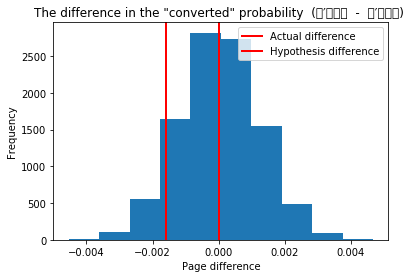

In [30]:
plt.hist(p_diffs)
plt.title('The difference in the "converted" probability  (𝑝′𝑛𝑒𝑤  -  𝑝′𝑜𝑙𝑑) ')
plt.xlabel('Page difference')
plt.ylabel('Frequency')
plt.axvline(x=obs_diff, color='r',linewidth=2, label="Actual difference")
plt.axvline(0, color='r',linewidth=2, label="Hypothesis difference")
plt.legend()


`So the histogram showed normal distribution for the simulated data as expected and the mean is 0 due to our null hypothesis assumption.`

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [31]:
p = (p_diffs > obs_diff).mean()
print ( ' The probability of the difference in the converted probability for "sampling under null Hypothesis" and "actual data" is ' , p )

 The probability of the difference in the converted probability for "sampling under null Hypothesis" and "actual data" is  0.91


**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**Answer:**    
> 1 : This value called in scientific studies the p-value.  
> 2: Since this value is greater than 0.05 so it's high probability that null hypothesis is true and we fail to reject the null hypothesis, so the new page does not lead to more conversion rate. 



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [32]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = ( df2[(df2['landing_page'] == 'old_page')& (df2['converted']==1)])['converted'].sum()

# number of conversions with the new_page
convert_new = (df2[(df2['landing_page'] == 'new_page')& (df2['converted']==1)])['converted'].sum()

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page'] == 'old_page']['user_id'].count()

# number of individuals who received new_page
n_new = df2[df2['landing_page'] == 'new_page']['user_id'].count()

print( 'Number of conversions with the old_page is ' ,convert_old)
print( 'Number of conversions with the new_page is ' , convert_new)
print( 'Number of individuals who were shown the old_page is ' ,n_old)
print( 'Number of individuals who received new_page is ', n_new )

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Number of conversions with the old_page is  17489
Number of conversions with the new_page is  17264
Number of individuals who were shown the old_page is  145274
Number of individuals who received new_page is  145310


**m.** Now we will use `sm.stats.proportions_ztest()` to compute our test statistic and p-value. 

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Note**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that we have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for our two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. We can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. We can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if our hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected if the $Z_{score}$ lies in that region.

>Where:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 

---


In [33]:
import statsmodels.api as sm
#  Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new, convert_old], nobs=[n_new, n_old],alternative='larger')
print( 'z_score is ', z_score )
print( 'p_value is ', p_value)

z_score is  -1.31092419842
p_value is  0.905058312759


**n.** What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Note**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can we reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

>**Answer: **    
>         After coding and getting 𝑍𝑠𝑐𝑜𝑟𝑒= -1.3 which less than 1.645, so we failed to reject null.    
And from j and k we found p value is greater than 0.05, so we failed to reject null as well.   
So the z-test agreed with previous findings that, the new page does not lead to more conversion rate.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should we be performing in this case?

>**Answer: **    
>Since data is either a conversion or no conversion, we can use the logistic regression.

**b.** The goal is to use **statsmodels** library to fit the regression model we specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [34]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** We will use **statsmodels** to instantiate our regression model on the two columns we created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [35]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** To provide the summary of our model below, and use it as necessary to answer the following questions.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-13 22:40 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Where**: 
- What are the null and alternative hypotheses associated with our regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- We need to comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- We need to also compare the current p-value with the Type I error rate (0.05).


>**Answer:**    
    >**Our null and alternative hypotheses ( 𝐻0  and  𝐻1 ) associated with our regression model are based on page type:**         
>**$H_0$** :  $p_{old}$ = $p_{new}$        # Conversion       
>**$H_1$** :  $p_{new}$ != $p_{old}$       # Not Conversion       
    > This hypotheses are two sided tailed while part|| was one side (right tailed).      
    >The p-value associated with ab_page is 0.1899 which is larger than 0.05 so we fail to reject the null hypotheses.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Answer:**   
    > Sure it's a good idea to correlate our prediction with more factors that may impact the decision to get better accuracy.     
    > Disadvantages of adding additional terms that they may have low impact and low correlation. so we need to avoid colinearty.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. We will need to read in the **countries.csv** dataset and merge together our `df2` datasets on the appropriate rows. We will call the resulting dataframe `df_merged`.

2. Does it appear that country had an impact on conversion?  To answer this question, we will consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. We will create dummy variables for these country columns. 
>**Note:** We will use `pandas.get_dummies()` to create dummy variables. **We will utilize two columns for the three dummy variables.** 


In [37]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
# Join with the df2 dataframe
df_merged = df2.set_index('user_id').join(countries.set_index('user_id'))
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [39]:
# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [40]:
# Fit your model, and summarize the results
lm2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
results2 = lm2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-13 22:40 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
US            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

`Giving p values and coef values, statistically country does not has a high significant impact on conversion`

**h. Fitting our model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  

>**Where**: 
- Giving all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can we reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [41]:
## Create the necessary additional columns.
df_merged["UK_page"] = df_merged["ab_page"] * df_merged["UK"]
df_merged["US_page"] = df_merged["ab_page"] * df_merged["US"]
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA,UK_page,US_page
user_id,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [42]:
## Fit the new model.
lm3=sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page', 'UK','US','UK_page','US_page']])
results3=lm3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-05-13 22:40 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
UK_page      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
US_page       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

`All p values here are greater than 0.05 so we don't have significant impact on conversion. `

>**Conclusion:**    

    Finally, statistically we don't have enough proves or evidance to reject the null hypothesis using p values, zscore and logistic coef model. Which mean that the new page is not better than the old page and the conversion rates bewtween both of them almost the same. Also type of page and countries don't have significant impact on the coversion rate.    
Our recommendation is to try to improve the new page quality to get better result and increase the conversion rate to the new page as maybe the old one is better or more accepted almost the same as the new one, so we can keep the old one untill enhancing the new one.


<a id='finalcheck'></a>
## Final Check!

Congratulations!  We have reached the end of the A/B Test Results project!  We are very proud of all we have accomplished!



In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0